In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightfm import LightFM
from scipy.sparse import coo_matrix
from scipy import sparse
import matplotlib.pyplot as plt

# Read data and basic facts about df

In [3]:
hike_data = pd.read_pickle('../data/all_hike_data')

In [5]:
hike_data.head(1)

,hike_name,hike_difficulty,hike_distance,hike_elevation,hike_type,hike_tags,hike_description,user_names,user_hrefs,user_texts,user_ratings,user_dates
0,Taft Point and The Fissures - California\n |...,EASY,2.3 miles,374 feet,Out & Back,"[kid friendly, birding, hiking, horseback ridi...",Taft Point and The Fissures is a 2.3 mile mode...,"[Soua Lee, Jeff Allen, Nicole Edmonds, Marie K...","[/members/soua-lee-3, /members/jeff-allen-41, ...",[Incredible hike! I would do this again althou...,"[5, 4, 5, 4, 1, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, ...","[2018-11-13 00:00:00, 2018-11-05 00:00:00, 201..."


In [7]:
hrefs = pd.Series(hike_data['user_hrefs'].sum())

In [58]:
print(str(hike_data.shape[0]) + ' hikes')
print(str(len(hrefs.unique())) + ' unique users')
print(str((hrefs.isnull() == False).sum()) + ' text reviews.')

sparsity = 226618 / (5367*105535) * 100
print('sparsity = ' + str(sparsity))

5367 hikes
105535 unique users
226618 text reviews.
sparsity = 0.0400097919100818


In [451]:
len(hrefs)

240346

# Correct hike names

In [4]:
def correct_hike_names(df):
    df['hike_name'] = df['hike_name'].str.replace('\n', '').str.replace('- California \| AllTrails', '').str.strip()

In [5]:
correct_hike_names(hike_data)

In [554]:
hike_data.head(1)

,hike_name,hike_difficulty,hike_distance,hike_elevation,hike_type,hike_tags,hike_description,user_names,user_hrefs,user_texts,user_ratings,user_dates,vect_rev
0,Taft Point and The Fissures,EASY,2.3 miles,374 feet,Out & Back,"[kid friendly, birding, hiking, horseback ridi...",Taft Point and The Fissures is a 2.3 mile mode...,"[Soua Lee, Jeff Allen, Nicole Edmonds, Marie K...","[/members/soua-lee-3, /members/jeff-allen-41, ...",[Incredible hike! I would do this again althou...,"[5, 4, 5, 4, 1, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, ...","[2018-11-13 00:00:00, 2018-11-05 00:00:00, 201...","[-0.11622179855923885, 0.18857444383948566, 0...."


# Hike tags

In [814]:
tag_count = dict(collections.Counter(hike_data['hike_tags'].sum()))

In [815]:
sorted_by_count = sorted(tag_count.items(), key=lambda x: x[1], reverse=True)

In [816]:
sorted_by_alphabet = sorted(tag_count.items(), key=lambda x: x[0])

In [817]:
sorted_by_count

[('hiking', 4982),
 ('views', 4612),
 ('walking', 4027),
 ('nature trips', 3919),
 ('birding', 3362),
 ('trail running', 3091),
 ('wild flowers', 2987),
 ('wildlife', 2689),
 ('forest', 2305),
 ('kid friendly', 2170),
 ('dogs on leash', 2034),
 ('no dogs', 1640),
 ('mountain biking', 1212),
 ('dog friendly', 980),
 ('lake', 968),
 ('river', 819),
 ('camping', 803),
 ('rocky', 706),
 ('backpacking', 671),
 ('horseback riding', 630),
 ('waterfall', 487),
 ('beach', 450),
 ('no shade', 399),
 ('bugs', 351),
 ('snow', 331),
 ('fishing', 268),
 ('scramble', 254),
 ('road biking', 252),
 ('partially paved', 250),
 ('off road driving', 211),
 ('over grown', 193),
 ('wheelchair friendly', 183),
 ('stroller friendly', 177),
 ('washed out', 149),
 ('snowshoeing', 138),
 ('rock climbing', 132),
 ('muddy', 130),
 ('paved', 128),
 ('historic site', 111),
 ('cave', 96),
 ('scenic driving', 92),
 ('city walk', 81),
 ('paddle sports', 76),
 ('closed', 56),
 ('surfing', 53),
 ('blowdown', 52),
 ('off t

In [818]:
delete_list = ['blowdown','bridge out', 'closed', 'muddy', 'no dogs', 'no shade', 'off road driving', 'off trail',
               'paddle sports', 'paved', 'private property', 'rails trails', 'surfing', 'washed out', 'city walk',
              'cross country skiing', 'hiking', 'partially paved', 'road biking', 'skiing', 'nature trips', 'snowshoeing',
              'dogs on leash']

In [819]:
final_tags = list(tag_count.keys())
for item in delete_list:
    final_tags.remove(item)
final_tags
# ADD dog friendly and dog on leash together

['kid friendly',
 'birding',
 'horseback riding',
 'trail running',
 'walking',
 'forest',
 'views',
 'wild flowers',
 'wildlife',
 'rocky',
 'mountain biking',
 'cave',
 'river',
 'wheelchair friendly',
 'stroller friendly',
 'lake',
 'rock climbing',
 'waterfall',
 'camping',
 'scenic driving',
 'bugs',
 'dog friendly',
 'fishing',
 'scramble',
 'snow',
 'backpacking',
 'beach',
 'historic site',
 'over grown',
 'hot springs']

In [867]:
tag_dict = {}
for feature in final_tags:
    if feature in hike_data.iloc[0]['hike_tags']:
        tag_dict[feature] = 1
    else:
        tag_dict[feature] = 0
if 'dogs on leash' in hike_data.iloc[0]['hike_tags']:
    tag_dict['dog friendly'] = 1

# Get features of each hike

In [633]:
unique_difficulties = hike_data['hike_difficulty'].unique() # unique hike difficulties
unique_types = hike_data['hike_type'].unique() # unique hike_types
unique_tags = set(hike_data['hike_tags'].sum())

In [634]:
hike_feature_df = hike_data.copy()
hike_feature_df['hike_distance'] = hike_feature_df['hike_distance'].str.extract('(\d+.\d)'); # extract distance
hike_feature_df['hike_elevation'] = hike_feature_df['hike_elevation'].str.replace(',', '').str.extract('(\d+)')

In [869]:
def get_hike_features(df, index):

    hike_features_dict = {}
    easy = 0
    moderate = 0
    hard = 0
    out_and_back = 0
    loop = 0
    point_to_point = 0

    if df.iloc[index]['hike_difficulty'] == 'EASY':
        easy = 1
    elif df.iloc[index]['hike_difficulty'] == 'MODERATE':
        moderate = 1
    else:
        hard = 1

    if df.iloc[index]['hike_type'] == 'Out & Back':
        out_and_back = 1
    elif df.iloc[index]['hike_type'] == 'Loop':
        loop = 1
    else:
        point_to_point = 1
        
    tag_dict = {}
    for feature in final_tags:
        if feature in hike_data.iloc[index]['hike_tags']:
            tag_dict[feature] = 1
        else:
            tag_dict[feature] = 0
    if 'dogs on leash' in hike_data.iloc[index]['hike_tags']:
        tag_dict['dog friendly'] = 1
        
    hike_distance = df.iloc[index]['hike_distance']
    hike_elevation = df.iloc[index]['hike_elevation']
        
    hike_features_dict['difficulty_easy'] = easy
    hike_features_dict['difficulty_moderate'] = moderate
    hike_features_dict['difficulty_hard'] = hard
    hike_features_dict['out_and_back'] = out_and_back
    hike_features_dict['loop'] = loop
    hike_features_dict['point_to_point'] = point_to_point
    hike_features_dict['hike_distance'] = float(hike_distance)
    hike_features_dict['hike_elevation'] = float(hike_elevation)
    for item in tag_dict.items(): # add tags in dict
        hike_features_dict[item[0]] = item[1]
    
    return hike_features_dict

In [870]:
hikes_features = {}
for index in hike_feature_df.index:
    hike_features_dict = get_hike_features(hike_feature_df, index)
    hikes_features[hike_feature_df.iloc[index]['hike_name']] = hike_features_dict

In [871]:
hikes_features_df = pd.DataFrame(hikes_features).T
hikes_features_df.head(5)

,backpacking,beach,birding,bugs,camping,cave,difficulty_easy,difficulty_hard,difficulty_moderate,dog friendly,...,scramble,snow,stroller friendly,trail running,views,walking,waterfall,wheelchair friendly,wild flowers,wildlife
Taft Point and The Fissures,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
Aliso Creek and Wood Canyon Loop Trail,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
Upper Natural Bridge Trail,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
Lake Miramar Trail,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
McGinty Mountain Trail,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0


In [873]:
logmean_hike_distance = np.mean(np.log(hikes_features_df['hike_distance'])) # log distance
logstd_hike_distance = np.std(np.log(hikes_features_df['hike_distance'])) # log distance
logmean_hike_elevation = np.mean(np.log(hikes_features_df['hike_elevation'][hikes_features_df['hike_elevation'] != 0]))
logstd_hike_elevation = np.std(np.log(hikes_features_df['hike_elevation'][hikes_features_df['hike_elevation'] != 0]))

In [97]:
logmean_hike_elevation, logstd_hike_elevation

(6.5567361600991525, 1.4124694061309393)

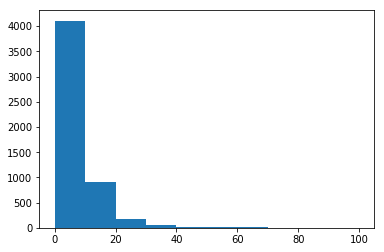

In [90]:
# histogram of distance is skewed
plt.hist(hikes_features_df['hike_distance'], bins=np.arange(0,110,10));

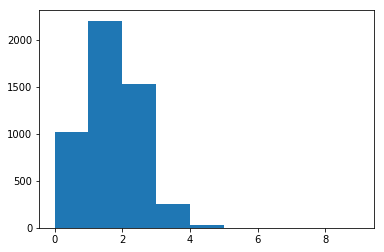

In [91]:
# histogram of log distance is more normal
plt.hist(np.log(hikes_features_df['hike_distance']), bins=range(10));

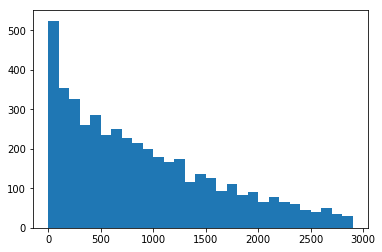

In [92]:
# histogram of distance is skewed
plt.hist(hikes_features_df['hike_elevation'], bins=np.arange(0,3000,100));

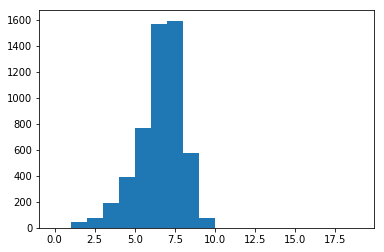

In [93]:
# histogram of distance is skewed
plt.hist(np.log(hikes_features_df['hike_elevation'][hikes_features_df['hike_elevation'] != 0]), bins=np.arange(0,20,1));

In [874]:
def classify_distance(row):
    if np.log(row) < logmean_hike_distance-logstd_hike_distance:
        return "Short"
    elif np.log(row) < logmean_hike_distance+logstd_hike_distance and np.log(row) > logmean_hike_distance-logstd_hike_distance:
        return "Medium"
    else:
        return "Long"

In [875]:
def classify_elevation(row):
    if np.log(row) < logmean_hike_elevation-logstd_hike_elevation:
        return "Easy"
    elif np.log(row) < logmean_hike_elevation+logstd_hike_elevation and np.log(row) > logmean_hike_elevation-logstd_hike_elevation:
        return "Medium"
    else:
        return "Hard"

In [876]:
categorized_distances = hikes_features_df['hike_distance'].apply(classify_distance)
categorized_elevations = hikes_features_df['hike_elevation'].apply(classify_elevation)

In [642]:
import collections
collections.Counter(categorized_distances), collections.Counter(categorized_elevations)

(Counter({'Medium': 3733, 'Short': 766, 'Long': 796}),
 Counter({'Medium': 3819, 'Easy': 799, 'Hard': 677}))

In [877]:
hikes_features_df['hike_elevation'] = categorized_elevations
hikes_features_df['hike_distance'] = categorized_distances

In [878]:
for index in hikes_features_df.index:
    if hikes_features_df.loc[index, 'hike_distance'] == 'Short':
        hikes_features_df.loc[index, 'distance_short'] = 1
    elif hikes_features_df.loc[index, 'hike_distance'] == 'Medium':
        hikes_features_df.loc[index, 'distance_medium'] = 1
    else:
        hikes_features_df.loc[index, 'distance_long'] = 1
        
    if hikes_features_df.loc[index, 'hike_elevation'] == 'Easy':
        hikes_features_df.loc[index, 'elevation_easy'] = 1
    elif hikes_features_df.loc[index, 'hike_elevation'] == 'Medium':
        hikes_features_df.loc[index, 'elevation_medium'] = 1
    else:
        hikes_features_df.loc[index, 'elevation_hard'] = 1

    
hikes_features_df.drop(labels='hike_distance', axis=1, inplace=True)
hikes_features_df.drop(labels='hike_elevation', axis=1, inplace=True)
hikes_features_df.fillna(0, inplace=True);

In [879]:
hikes_features_df.head()

,backpacking,beach,birding,bugs,camping,cave,difficulty_easy,difficulty_hard,difficulty_moderate,dog friendly,...,waterfall,wheelchair friendly,wild flowers,wildlife,distance_medium,elevation_medium,elevation_easy,distance_short,distance_long,elevation_hard
Taft Point and The Fissures,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
Aliso Creek and Wood Canyon Loop Trail,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
Upper Natural Bridge Trail,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
Lake Miramar Trail,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
McGinty Mountain Trail,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


In [880]:
hikes_features_df.shape

(5295, 42)

In [881]:
df = pd.read_pickle('hike_data_filtered_190124')

In [882]:
hikes_features_df = hikes_features_df.loc[df.columns] # limit df to those hikes in interaction matrix

In [883]:
hikes_features_df = hikes_features_df[~hikes_features_df.index.duplicated(keep='last')]

In [884]:
hikes_features_df.shape

(616, 42)

In [885]:
hikes_features_df.to_pickle('hike_features_190129')

## Inputing item_features to LightFM model

In [886]:
hikes_features_df = pd.read_pickle('hike_features_190129')
df = pd.read_pickle('hike_data_filtered_190124')

In [887]:
item_features = hikes_features_df.columns
hike_features_dict = {row: column.dropna().to_dict() for row, column in hikes_features_df.T[hikes_features_df.T != 0].T.iterrows()}

In [888]:
from lightfm import data
from lightfm import cross_validation
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score
from lightfm.evaluation import precision_at_k

In [914]:
def lightfm_implicit_matrix(df, hikes_features_df):
    dataset = data.Dataset() # Instantiate class
    dataset.fit(users=(user for user in df.index),
                items=(feature for feature in df.columns),
                item_features=(feature for feature in hikes_features_df.columns)) # Create users and items from df
    num_users, num_items = dataset.interactions_shape() # Get shape
    interaction_list = list(df[df > 0].stack().index) # Get interaction pairs
    interactions, weights = dataset.build_interactions((x[0], x[1]) for x in interaction_list) # Build interactions
    hike_features_dict = {row: column.dropna().to_dict() for row, column in hikes_features_df.T[hikes_features_df.T != 0].T.iterrows()}
    feature_matrix = dataset.build_item_features([ (key, value) for key,value in hike_features_dict.items() ]) # Build item_features matrix
    
    return dataset, interactions, feature_matrix

def lightfm_train(train, item_features, num_components=30, num_epochs=10, learning_rate=0.05):
    num_threads = 1
    item_alpha = 1e-6
    learning_rate = learning_rate

    # Let's fit a WARP model: these generally have the best performance.
    model = LightFM(loss='warp',
                    learning_rate = learning_rate,
                    item_alpha=item_alpha,
                    no_components=num_components)

    model = model.fit(interactions=train, item_features=item_features, epochs=num_epochs, num_threads=num_threads)
    
    return model

def find_item(lfm_map, lfm_index):
    return [ key for key in lfm_map.keys() if lfm_map[key] == lfm_index ][0]

def return_top_10_new_user(interactions, model, item_map):
    predictions = model.predict(interactions._shape[0]-1, np.arange(interactions._shape[1]))
    sorted_by_index = (-1*predictions).argsort()
    names = []
    
    for pred_num in range(10):
        name = find_item(item_map, sorted_by_index[pred_num])
        print('Prediction {} is {}.'.format(pred_num+1, name))
        names.append(name)
        
    return names

In [916]:
dataset, interactions, feature_matrix = lightfm_implicit_matrix(df, hikes_features_df)
train, test = cross_validation.random_train_test_split(interactions, test_percentage=0.2, random_state=np.random.RandomState(seed=1))
model = lightfm_train(train, feature_matrix, 30, 30)

In [919]:
# Compute and print the AUC score
train_auc = auc_score(model=model, test_interactions=train, item_features=feature_matrix, num_threads=30).mean()
print('Collaborative filtering train AUC: %s' % train_auc)

Collaborative filtering train AUC: 0.84495413


In [920]:
# We pass in the train interactions to exclude them from predictions.
# This is to simulate a recommender system where we do not
# re-recommend things the user has already interacted with in the train
# set.
test_auc = auc_score(model=model, test_interactions=test, train_interactions=train, item_features=feature_matrix, num_threads=30).mean()
print('Collaborative filtering test AUC: %s' % test_auc)

Collaborative filtering test AUC: 0.7433645


In [921]:
for k in range(1,11):
    precision = precision_at_k(model, test_interactions=test, train_interactions=train, item_features=feature_matrix, k=k).mean()
    print('Precision at k = {} is {:.2f}'.format(k, precision))

Precision at k = 1 is 0.05
Precision at k = 2 is 0.05
Precision at k = 3 is 0.04
Precision at k = 4 is 0.04
Precision at k = 5 is 0.04
Precision at k = 6 is 0.03
Precision at k = 7 is 0.03
Precision at k = 8 is 0.03
Precision at k = 9 is 0.03
Precision at k = 10 is 0.03


In [894]:
grid_search = {}
count = 0
for learning_rate in [1e-4, 1e-3, 1e-2, 1e-1, 1]:
    for num_epochs in [20, 40, 60, 80, 100]:
        for num_components in [20, 40, 60, 80, 100]:
            dataset, interactions, feature_matrix = lightfm_implicit_matrix(df, hikes_features_df)
            train, test = cross_validation.random_train_test_split(interactions, test_percentage=0.2, random_state=np.random.RandomState(seed=1))
            model = lightfm_train(train, num_components=num_components, num_epochs=num_epochs, learning_rate=learning_rate)
            test_auc = auc_score(model, test, train_interactions=train, num_threads=1).mean()
            precision = precision_at_k(model, test, train_interactions=train, k=5).mean()
            grid_search[count] = {'lr': learning_rate, 'ne': num_epochs, 'nc': num_components, 'auc': test_auc, 'precision': precision}
            count += 1

In [895]:
sorted(grid_search.items(), key=lambda x: x[1]['precision'], reverse=True)[:5]

[(74,
  {'lr': 0.01,
   'ne': 100,
   'nc': 100,
   'auc': 0.86767006,
   'precision': 0.07846154}),
 (68,
  {'lr': 0.01, 'ne': 80, 'nc': 80, 'auc': 0.8631809, 'precision': 0.07589744}),
 (73,
  {'lr': 0.01,
   'ne': 100,
   'nc': 80,
   'auc': 0.8669553,
   'precision': 0.07589744}),
 (72,
  {'lr': 0.01,
   'ne': 100,
   'nc': 60,
   'auc': 0.86098725,
   'precision': 0.07435898}),
 (67,
  {'lr': 0.01, 'ne': 80, 'nc': 60, 'auc': 0.8572133, 'precision': 0.07418804})]

In [906]:
dataset, interactions, feature_matrix = lightfm_implicit_matrix(df, hikes_features_df)
train, test = cross_validation.random_train_test_split(interactions, test_percentage=0.2, random_state=np.random.RandomState(seed=1))
model = lightfm_train(train, num_components=30, num_epochs=30, learning_rate=0.01)
test_auc = auc_score(model, test, train_interactions=train, item_features = feature_matrix, num_threads=1).mean()
precision = precision_at_k(model, test, train_interactions=train, item_features = feature_matrix, k=5).mean()
print(test_auc, precision)

ValueError: The item feature matrix specifies more features than there are estimated feature embeddings: 616 vs 658.

In [902]:
precision_at_k(model, test, train_interactions=train, k=5).mean()

0.057264958

In [800]:
df.apply(np.sum).sort_values(ascending=False)[:5]

Icehouse Canyon to Cucamonga Peak Trail        167.0
Bridge to Nowhere via East Fork Trail          123.0
Vernal and Nevada Falls via the Mist Trail     120.0
Vivian Creek Trail to San Gorgonio Peak        119.0
Mount San Antonio & Mount Baldy Notch Trail    106.0
dtype: float64

In [811]:
df.apply(np.sum).sort_values(ascending=False)[:5].sum() / (df.shape[0]*5)

0.09243085880640466

# Make matrix for collab filt

In [172]:
def gen_collabfilt_matrix(df):

    hike_user_rating_dict = {}
    for hike_index in range(df.shape[0]):
        hike_name = df.loc[hike_index, 'hike_name']
        user_names = df.loc[hike_index, 'user_names']
        user_ratings = df.loc[hike_index, 'user_ratings']
        
        user_rating_dict = {}
        for user_index in range(len(user_names)):
            user_rating_dict[user_names[user_index]] = user_ratings[user_index]
        
        hike_user_rating_dict[hike_name] = user_rating_dict
    
    return pd.DataFrame(hike_user_rating_dict, dtype='int')

In [173]:
hike_user_rating_matrix = gen_collabfilt_matrix(hike_data)

In [189]:
def convert_to_binary(df, cutoff):
    df = df.fillna(0)
    df[df < cutoff] = 0
    df[df > cutoff] = 1
    
    return df

In [1499]:
rated_or_not = convert_to_binary(hike_user_rating_matrix, 0.5)

In [1501]:
user_rating_counts = rated_or_not.apply(np.sum, axis=1)

In [ ]:
user_rating_counts.plot()

In [204]:
hike_user_rating_matrix_bool = convert_to_binary(hike_user_rating_matrix, 3.5)

In [208]:
# filter if user has less than 10 reviews
hike_user_rating_matrix_bool_filtered = hike_user_rating_matrix_bool[hike_user_rating_matrix_bool.apply(np.sum, axis=1) > 10]

In [278]:
def get_basic_stats(df):

    num_users = df.shape[0]
    num_hikes = df.shape[1]
    num_ratings = df.values.sum()
    sparsity = num_ratings / (num_hikes * num_users) * 100

    print('Number of hikes: ' + str(num_hikes))
    print('Number of users: ' + str(num_users))
    print('Number of ratings: {:.0f}'.format(num_ratings))
    print('Sparsity = {:4.2f}%'.format(sparsity))

In [279]:
get_basic_stats(hike_user_rating_matrix_bool_filtered)

Number of hikes: 5295
Number of users: 1374
Number of ratings: 24485
Sparsity = 0.34%


In [449]:
'{:.2f}%'.format(24485 / 226618 * 100)

'10.80%'

In [228]:
# filter if hike has no ratings
hike_user_rating_matrix_bool_filtered2 = hike_user_rating_matrix_bool_filtered.loc[:, (hike_user_rating_matrix_bool_filtered != 0).any(axis=0)]

In [280]:
get_basic_stats(hike_user_rating_matrix_bool_filtered2)

Number of hikes: 3606
Number of users: 1374
Number of ratings: 24485
Sparsity = 0.49%


In [448]:
'{:.2f}%'.format(24485 / 226618 * 100)

'10.80%'

In [ ]:
# filter if hike has less than 10 ratings

In [238]:
hike_user_rating_matrix_bool_filtered3 = hike_user_rating_matrix_bool_filtered2.loc[:, hike_user_rating_matrix_bool_filtered2.apply(np.sum, axis=0) > 10]

In [281]:
get_basic_stats(hike_user_rating_matrix_bool_filtered3)

Number of hikes: 616
Number of users: 1374
Number of ratings: 15288
Sparsity = 1.81%


In [447]:
'{:.2f}%'.format(15288 / 226618 * 100)

'6.75%'

In [452]:
hike_user_rating_matrix_bool_filtered3.head(5)

,Taft Point and The Fissures,Aliso Creek and Wood Canyon Loop Trail,Upper Natural Bridge Trail,Lake Miramar Trail,San Antonio Falls Trail,The Slot,Panoramic Hill - Chaparral Peak - Strawberry Canyon Loop,Lafayette Reservoir Nature Area Rim Trail,Cleo's Bath Trail via Pinecrest Lake Loop,Devil's Slide to Saddle Junction Trail,...,Rae Lakes Trail,Congress Trail,Strawberry Canyon Fire Trail,Annie's Canyon via North Rios Trail,Lake Margaret Trail,Deep Creek Hot Springs Trail,Cougar Crest Trail,Abalone Cove Trail,"Torrey Pines - Red Butte, Yucca Point, and Razor Point",Soberanes Canyon Trail
Bill Friedman,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
$15 $40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
** watson **,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3IrinaAmira D.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
@rafiky _resiii,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [927]:
pd.Series(hike_user_rating_matrix_bool_filtered3.columns).to_pickle('column_names')

In [1486]:
hike_user_rating_matrix_bool_filtered3.to_pickle('hike_data_filtered_190124')

In [942]:
hike_list = list(hike_user_rating_matrix_bool_filtered3.columns)

# Fit model using LightFM

## Automatic

In [365]:
from lightfm import data
from lightfm import cross_validation
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score
from lightfm.evaluation import precision_at_k

In [366]:
def lightfm_implicit_matrix(df):
    dataset = data.Dataset() # Instantiate class
    dataset.fit((user for user in df.index),
                (feature for feature in df.columns)) # Create users and items from df
    num_users, num_items = dataset.interactions_shape() # Get shape
    interaction_list = list(df[df > 0].stack().index) # Get interaction pairs
    interactions, weights = dataset.build_interactions((x[0], x[1]) for x in interaction_list) # Build interactions
    
    return dataset, interactions

def lightfm_train(train, num_components, num_epochs):
    NUM_THREADS = 1
    NUM_COMPONENTS = num_components
    NUM_EPOCHS = num_epochs
    ITEM_ALPHA = 1e-6

    # Let's fit a WARP model: these generally have the best performance.
    model = LightFM(loss='warp',
                    item_alpha=ITEM_ALPHA,
                   no_components=NUM_COMPONENTS)

    # Run 3 epochs and time it.
    model = model.fit(train, epochs=NUM_EPOCHS, num_threads=NUM_THREADS)
    
    return model

def find_item(lfm_map, lfm_index):
    return [ key for key in lfm_map.keys() if lfm_map[key] == lfm_index ][0]

def return_top_10_new_user(interactions, model, item_map):
    predictions = model.predict(interactions._shape[0]-1, np.arange(interactions._shape[1]))
    sorted_by_index = (-1*predictions).argsort()
    names = []
    
    for pred_num in range(10):
        name = find_item(item_map, sorted_by_index[pred_num])
        print('Prediction {} is {}.'.format(pred_num+1, name))
        names.append(name)
        
    return names

In [367]:
interaction_matrix = pd.read_pickle('hike_data_filtered_190124')

In [370]:
# Code to quickly instantiate class and train model

dataset, interactions = lightfm_implicit_matrix(interaction_matrix)
train, test = cross_validation.random_train_test_split(interactions, test_percentage=0.2, random_state=np.random.RandomState(seed=1))
model = lightfm_train(train, 30, 30)

item_map = dataset.mapping()[2]
recommended_hikes = return_top_10_new_user(interactions, model, item_map)

Prediction 1 is Berry Creek Falls Loop.
Prediction 2 is Strawberry Canyon Fire Trail.
Prediction 3 is Whittemore Gulch and Harkins Ridge Loop Trail.
Prediction 4 is Castle Rock Trail to Saratoga Gap Trail and Ridge Trail Loop.
Prediction 5 is Lexington Reservoir Trail.
Prediction 6 is Cataract Falls Trail, High Marsh, Kent Trail, and Helen Market Trail.
Prediction 7 is Mission Peak Loop from Stanford Avenue Staging Area.
Prediction 8 is Baltimore Canyon Via Dawn Falls Trail Loop.
Prediction 9 is Dunn, Graham and West Ridge Trail Loop.
Prediction 10 is East Ridge Trail to West Ridge Trail Loop from Skyline Blvd.


In [1492]:
item_map['Taft Point and The Fissures']

0

In [1377]:
def time_func():

    dataset, interactions = lightfm_implicit_matrix(hike_user_rating_matrix_bool_filtered3)
    lighfm_train = lightfm_train(interactions, 30, 5)

    item_mapping = dataset.mapping()[2]
    return_top_10_new_user(interactions, item_mapping)

In [1378]:
%timeit time_func

28.1 ns ± 0.448 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [1295]:
model.get_item_representations()[1].shape # item embeddings

(616, 30)

In [1488]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim

def calculate_similarities(model, hike_index_of_interest):
    item_embeddings = model.get_item_representations()[1]
    sim_scores = []
    for item_index in range(item_embeddings.shape[0]):
        sim_scores.append(cos_sim(item_embeddings[item_index, :], item_embeddings[hike_index_of_interest, :]))
        
    return sim_scores

def get_top_hikes_by_similarity(sim_scores, item_map):
    top_items = (-1*np.array(sim_scores)).argsort()
    names = []
    for pred_num in range(10):
        name = find_item(item_map, top_items[pred_num])
        names.append(name)
    
    return names

In [1490]:
sim_scores = calculate_similarities(model, 100)
top_hikes = get_top_hikes_by_similarity(sim_scores, item_map)
top_hikes

['Klondike and Portuguese Canyon Trails',
 'Venice Canals Trail',
 'La Canada Teepee via Crosstown Trail',
 'Paintbrush Trail to Portugese Bend',
 'Old Zoo Trail',
 'Inspiration Point Trail',
 'Santa Paula Canyon and Punch Bowls Trail',
 'Abalone Cove Trail',
 'Corral Canyon Loop Trail [CLOSED]',
 'Escondido Falls Trail [CLOSED]']

## Single model validation

Without the function, first try to validate model

In [1179]:
test_dataset = data.Dataset()

In [1180]:
test_dataset.fit((user for user in hike_user_rating_matrix_bool_filtered3.index),
                 (feature for feature in hike_user_rating_matrix_bool_filtered3.columns))

In [1181]:
num_users, num_items = test_dataset.interactions_shape()

In [1182]:
interaction_list = list(hike_user_rating_matrix_bool_filtered3[hike_user_rating_matrix_bool_filtered3 > 0].stack().index)

In [1183]:
interactions, weights = test_dataset.build_interactions((x[0], x[1]) for x in interaction_list)

In [1184]:
print(repr(interactions))

<1374x616 sparse matrix of type '<class 'numpy.int32'>'
	with 15288 stored elements in COOrdinate format>


In [1194]:
train, test = cross_validation.random_train_test_split(interactions, test_percentage=0.2)

In [1195]:
# Set the number of threads; you can increase this
# ify you have more physical cores available.
NUM_THREADS = 1
NUM_COMPONENTS = 30
NUM_EPOCHS = 5
ITEM_ALPHA = 1e-6

# Let's fit a WARP model: these generally have the best performance.
model = LightFM(loss='warp',
                item_alpha=ITEM_ALPHA,
               no_components=NUM_COMPONENTS)

# Run 3 epochs and time it.
%time model = model.fit(train, epochs=NUM_EPOCHS, num_threads=NUM_THREADS)

CPU times: user 149 ms, sys: 3.75 ms, total: 153 ms
Wall time: 153 ms


In [1196]:
# Compute and print the AUC score
train_auc = auc_score(model, train, num_threads=NUM_THREADS).mean()
print('Collaborative filtering train AUC: %s' % train_auc)

Collaborative filtering train AUC: 0.89639276


In [1197]:
# We pass in the train interactions to exclude them from predictions.
# This is to simulate a recommender system where we do not
# re-recommend things the user has already interacted with in the train
# set.
test_auc = auc_score(model, test, train_interactions=train, num_threads=NUM_THREADS).mean()
print('Collaborative filtering test AUC: %s' % test_auc)

Collaborative filtering test AUC: 0.82041705


In [1198]:
for k in range(1,11):
    precision = precision_at_k(model, test, train_interactions=train, k=k).mean()
    print('Precision at k = {} is {:.2f}'.format(k, precision))

Precision at k = 1 is 0.09
Precision at k = 2 is 0.08
Precision at k = 3 is 0.07
Precision at k = 4 is 0.07
Precision at k = 5 is 0.06
Precision at k = 6 is 0.06
Precision at k = 7 is 0.06
Precision at k = 8 is 0.05
Precision at k = 9 is 0.05
Precision at k = 10 is 0.05


In [1200]:
return_top_10_new_user(interactions, model, item_mapping)

Prediction 1 is Upper Rustic Garapito Loop Trail.
Prediction 2 is Los Penasquitos Canyon Trail.
Prediction 3 is Homestead-Blue Ridge Trail.
Prediction 4 is Sierra Buttes Lookout Trail.
Prediction 5 is Weaver Lake Trail.
Prediction 6 is Golden Gate Bridge from Baker Beach Trail.
Prediction 7 is Montara Mountain Trail.
Prediction 8 is Sage Trail to Cougar Ridge Trail to Boulder Loop.
Prediction 9 is Smith Mountain Trail.
Prediction 10 is Stout Memorial Grove Trail.


Expected precision at k from hypergeometric distribution

In [3]:
hike_data_filt = pd.read_pickle('hike_data_filtered_190124')

In [47]:
num_interactions = hike_data_filt.apply(np.sum).sum()
num_users = hike_data_filt.shape[0]
num_hikes = hike_data_filt.shape[1]
print('Number of hikes: {}, Average number of interactions per user: {:2f}'.format(num_hikes, average_interactions_per_user))

Number of hikes: 616, Average number of interactions per user: 11.126638


In [48]:
def random_precision_at_k(num_hikes, num_users, num_interactions):
    '''Calculates the expected precision-at-k for random guessing. The expected fraction of recommended hikes that are
    true positives in the interaction matrix is given by the mean of the hypergeometric distribution with population
    size num_hikes, number of successess num_interactions / num_users, and number of draws num_recommendations. 
    The expected fraction of recommended hikes that are true positives in the interaction matrix is given by that mean
    divided by the numer of recommendations.
    
    Returns: expected fraction of recommended hikes that are true positives in interaction matrix. '''
    
    num_hikes_expected = num_recommendations * (num_interactions / num_users) / num_hikes
    return num_hikes_expected / num_recommendations

In [69]:
random_precision_at_10 = random_precision_at_k(num_hikes, num_users, num_interactions, 10)
random_precision_at_1 = random_precision_at_k(num_hikes, num_users, num_interactions, 1)
print('Random precision-at-10 is: {:.3f}'.format(random_precision_at_10))
print('Random precision-at-1 is: {:.3f}'.format(random_precision_at_1))

Random precision-at-10 is: 0.018
Random precision-at-1 is: 0.018


In [71]:
upper_bound = 0.10 / random_precision_at_1 * 100
lower_bound = 0.05 / random_precision_at_10 * 100
print('Collaborative filtering model is {:.0f}% to {:.0f}% better than random guessing'.format(lower_bound, upper_bound))

Collaborative filtering model is 277% to 554% better than random guessing


# Appending new user to dataframe

Appending new item to dataframe

In [611]:
def csr_vappend(a,b):
    """ Takes in 2 csr_matrices and appends the second one to the bottom of the first one. 
    Much faster than scipy.sparse.vstack but assumes the type to be csr and overwrites
    the first matrix instead of copying it. The data, indices, and indptr still get copied."""

    a.data = np.hstack((a.data,b.data))
    a.indices = np.hstack((a.indices,b.indices))
    a.indptr = np.hstack((a.indptr,(b.indptr + a.nnz)[1:]))
    a._shape = (a.shape[0]+b.shape[0],b.shape[1])
    return a

In [631]:
new_user_hike_dict = {}
for hike in hike_user_rating_matrix_bool_filtered3.columns:
    new_user_hike_dict[hike] = 0

new_user_hike_dict['Taft Point and The Fissures'] = 1.0
insert_dict = {'new user': new_user_hike_dict}

In [716]:
initial_matrix = sparse.csr_matrix(hike_user_rating_matrix_bool_filtered3)
insert_matrix = sparse.csr_matrix(pd.DataFrame(insert_dict).T)

In [717]:
test_stack = csr_vappend(initial_matrix, insert_matrix)

Note: new_user will have user_index = initial_matrix._shape + 1

# Get user features based on hikes rated

In [134]:
hike_data = pd.read_pickle('hike_data_filtered_190124')

In [135]:
nz_entries = hike_data[hike_data>0].stack()

In [136]:
for user in nz_entries.index.get_level_values(0).unique(): # each unique user
    rated_hikes = hike_data.loc[user] # dataframe containing rated hikes
        

In [138]:
hikes_features_df.loc[nz_entries[' Bill Friedman'].index]

,easy,hard,hike_distance,hike_elevation,loop,moderate,out_and_back,point_to_point
"Woods, Winnemucca, and Round Top Lakes",0.0,0.0,4.9,1272.0,1.0,1.0,0.0,0.0
Canyon View Loop Trail,0.0,0.0,3.6,623.0,1.0,1.0,0.0,0.0
Big Meadow to Dardanelles Lake via Tahoe Rim Trail,0.0,0.0,7.3,1358.0,0.0,1.0,1.0,0.0
Bayview Trail to Velma Lakes,0.0,0.0,9.9,2378.0,0.0,1.0,1.0,0.0
Bump and Grind Trail,0.0,0.0,3.9,1108.0,1.0,1.0,0.0,0.0
Lost Palms Oasis,0.0,0.0,7.2,1026.0,0.0,1.0,1.0,0.0


In [1284]:
median_dist = hikes_features_df.loc[nz_entries[' Bill Friedman'].index, 'hike_distance'].median()
median_elev = hikes_features_df.loc[nz_entries[' Bill Friedman'].index, 'hike_elevation'].median()

# Visualizations

Distribution of Ratings

In [252]:
from collections import Counter

In [248]:
rating_list = hike_data['user_ratings'].sum()

In [257]:
rating_list_counter = Counter(rating_list)

In [265]:
ratings_values, ratings_count = rating_list_counter.keys(), rating_list_counter.values()

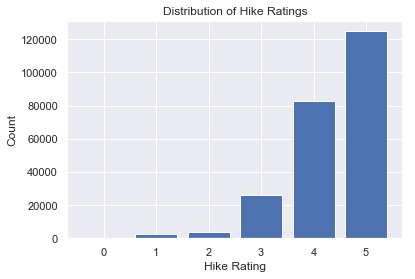

In [1493]:
sns.set()
plt.bar(ratings_values, ratings_count)
plt.xlabel('Hike Rating')
plt.ylabel('Count')
plt.title('Distribution of Hike Ratings')
plt.savefig('Distribution of Hike Ratings.png', dpi=300, bbox_inches='tight');

Number of ratings

In [240]:
rated_or_not = convert_to_binary(hike_user_rating_matrix, 0.5)

In [246]:
rated = rated_or_not.values.sum()
not_rated = rated_or_not.shape[0] * rated_or_not.shape[1] - rated

print('Number of ratings: ' + str(int(rated)) + '.')
print('Number of no-ratings ' + str(int(not_rated)) + '.')

Number of ratings: 222987.
Number of no-ratings 552755043.


In [1110]:
num_ratings_per_hike = hike_user_rating_matrix_bool.apply(sum)

In [1111]:
x=[]
y=[]
for number in range(100):
    count = 0
    for num_hikes in num_ratings_per_hike.values:
        if num_hikes > number:
            count += 1
    x.append(number)
    y.append(count)

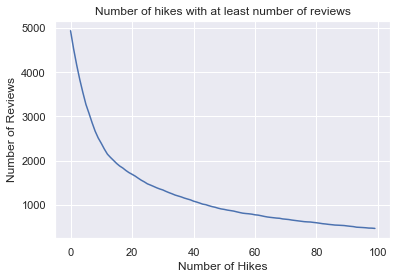

In [1115]:
plt.plot(x, y)
plt.xlabel('Number of Hikes')
plt.ylabel('Number of Reviews')
plt.title('Number of hikes with at least number of reviews')
plt.savefig('NumReviews vs. NumHikes.png', dpi=300, bbox_inches='tight')

In [1116]:
num_ratings_per_user = hike_user_rating_matrix_bool.apply(sum, axis=1)

In [1117]:
x=[]
y=[]
for number in range(100):
    count = 0
    for num_rating in num_ratings_per_user.values:
        if num_rating > number:
            count += 1
    x.append(number)
    y.append(count)

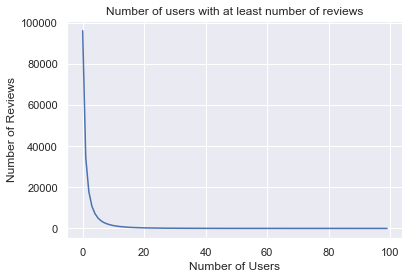

In [1118]:
plt.plot(x, y)
plt.xlabel('Number of Users')
plt.ylabel('Number of Reviews')
plt.title('Number of users with at least number of reviews')
plt.savefig('NumReviews vs. NumUsers.png', dpi=300, bbox_inches='tight')

# NLP

In [100]:
import string
import re
import spacy
import gensim
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
punctuation = string.punctuation

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stefanheinze/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [101]:
example = ' '.join(hike_data.loc[0, 'user_texts'])
example = re.sub("""[{}]""".format(punctuation), '', example) # get rid of punctuation
example = re.sub('\s{2,10}', ' ', example) # remove extra whitespace
example = example.lower() # make lower case

In [102]:
example[:100]

'incredible hike i would do this again although i wouldnt try to be daring due to the recent death th'

In [103]:
example_words = gensim.utils.simple_preprocess(example, deacc=True)

In [105]:
def remove_stopwords(word_list):
    #return [[word for word in example_words if word not in stop_words] for doc in texts]
    return [ word for word in word_list if word not in stop_words ]

In [106]:
example_words_filt = remove_stopwords(example_words)

In [110]:
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(string, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = [] 
    texts_out.append([token.lemma_ for token in nlp(string) if token.pos_ in allowed_postags])
    
    return texts_out

In [111]:
lemmatized = lemmatization(' '.join(example_words_filt))

In [117]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

(400000, 100)

In [118]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = 'glove.6B.100d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)

## Reviews to array

In [181]:
def review2vec(review):
    vec = np.array([0]*100, dtype='float64')
    for word in review:
        try:
            word_vec = model[word]
            vec += word_vec
        except KeyError:
            pass
        
    av_vec = vec / len(review) 
    return av_vec

In [263]:
def reviews2array(reviews):
    num_hikes = len(reviews)
    #vectorized_reviews = np.ndarray((num_hikes, 100))
    vectorized_reviews = []
    for index, review in enumerate(reviews):
        #vectorized_reviews[index] = review2vec(review)
        vectorized_reviews.append(review2vec(review))
    
    return vectorized_reviews

In [218]:
hike_reviews = hike_data['user_texts'].apply(' '.join)
hike_reviews = hike_reviews.str.replace("""[{}]""".format(punctuation), '')
hike_reviews = hike_reviews.str.replace('\s{2,10}', ' ')
hike_reviews = hike_reviews.str.lower()
hike_reviews = hike_reviews.apply(gensim.utils.simple_preprocess)
hike_reviews = hike_reviews.apply(remove_stopwords)

In [264]:
reviews_array = reviews2array(hike_reviews)

/Users/stefanheinze/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [269]:
hike_data['vect_rev'] = pd.Series(reviews_array)

In [293]:
def find_most_similar(rev_vec_series, item_index):
    similarity_list = []
    item_vect_rev = rev_vec_series[item_index]
    for index in np.delete(np.arange(0, len(hike_data)), item_index):
        similarity_list.append((index, rev_vec_series[index].dot(item_vect_rev)))

    return similarity_list

In [307]:
sim_list_test = find_most_similar(hike_data['vect_rev'], 64)

In [308]:
sorted(sim_list_test, key=lambda x: x[1], reverse=True)[0]

(376, 10.856210699569532)

In [309]:
hike_data.iloc[376]

hike_name                                            Burma Road Trail
hike_difficulty                                              MODERATE
hike_distance                                               4.7 miles
hike_elevation                                               994 feet
hike_type                                                  Out & Back
hike_tags           [dogs on leash, kid friendly, birding, hiking,...
hike_description    Burma Road Trail  is a 4.7 mile moderately tra...
user_names          [Dava Choi, Anthony Myers, Janeece M., Summer ...
user_hrefs          [/members/dava-choi, /members/anthony-myers-4,...
user_texts          [Great view. Nice hike., Great views, nice hik...
user_ratings        [5, 5, 5, 5, 3, 5, 5, 5, 5, 3, 3, 5, 5, 4, 5, ...
user_dates          [2019-01-03 00:00:00, 2018-05-26 00:00:00, 201...
vect_rev            [-0.13030253938399255, 0.2535805183276534, 0.3...
Name: 376, dtype: object

In [360]:
hike_data[hike_data['hike_name'].str.contains('General')]

,hike_name,hike_difficulty,hike_distance,hike_elevation,hike_type,hike_tags,hike_description,user_names,user_hrefs,user_texts,user_ratings,user_dates,vect_rev
142,General Grant Loop Trail,EASY,0.5 miles,29 feet,Loop,"[wheelchair friendly, kid friendly, stroller f...",General Grant Loop Trail is a 0.5 mile heavily...,"[Jim F, Shayla S, Sam@ NationalParksTrails, MA...","[/members/calicanes, /members/shayla-brown-5, ...","[Not much of a hike but some amazing Redwoods,...","[5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, ...","[2018-11-11 00:00:00, 2018-10-16 00:00:00, 201...","[-0.10695524348130513, 0.3126886366544278, 0.2..."
3878,General Creek,EASY,3.0 miles,150 feet,Out & Back,"[hiking, nature trips, trail running, walking]",General Creek is a 3 mile moderately trafficke...,"[Brandi McPherson, Rob Cromar, Brian D'Andrea,...","[/members/brandi-mcpherson, /members/rob-croma...","[, , , ]","[3, 5, 5, 4]","[2018-12-28 00:00:00, 2018-11-24 00:00:00, 201...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
5308,General Sherman Tree Trail,EASY,0.8 miles,154 feet,Out & Back,"[wheelchair friendly, kid friendly, stroller f...",General Sherman Tree Trail is a 0.8 mile heavi...,"[Sam Kreis, Suzanna Ruelas, Joey Castillo, Geo...","[/members/sam-kreis, /members/suzanna-ruelas-1...",[It was cool to see the biggest tree in the wo...,"[2, 5, 1, 5, 2, 4, 4, 4, 4, 4, 5, 4, 4, 5, 4, ...","[2019-01-10 00:00:00, 2018-12-31 00:00:00, 201...","[-0.12752579056722668, 0.29628783964134325, 0...."


In [362]:
word_vec = model['general']
similarity_list = []
for index in np.arange(0, len(hike_data)):
    similarity_list.append((index, hike_data['vect_rev'][index].dot(word_vec)))

In [363]:
sorted(similarity_list, key=lambda x: x[1], reverse=True)[:10]

[(694, 9.965930058825501),
 (1062, 9.599591474957245),
 (376, 9.530373870153332),
 (518, 9.473391842386679),
 (1092, 9.434391302166258),
 (57, 9.33796626178188),
 (168, 9.312606189865567),
 (596, 9.305459514716691),
 (1086, 9.291528375486656),
 (450, 9.252814680451166)]

In [364]:
for item in sorted(similarity_list, key=lambda x: x[1], reverse=True)[:10]:
    print(hike_data.loc[item[0], 'hike_name'])

South Plateau Trail to Bird Island
Glendora Mountain Way Trail
Burma Road Trail
Castle Rock Peak
Crafts Peak Trail
Vernal Falls
Indian Joe Nature, Indian Joe Creek, Cave Rocks Road, High Valley Road, Flag Hill Road, Flag Hill Trails
Twin Peaks Trail
Down and Up Trail Loop
Coastal and Fox Trails Loop


## Inputing item_features to LightFM model

In [461]:
df = pd.read_pickle('hike_data_filtered_190124') # get interaction data
hike_data_name_index = hike_data.set_index('hike_name') # set index of full dataset to hike name
df = hike_data_name_index.loc[df.columns] # limit df to those hikes in interaction matrix
df = df[~df.index.duplicated(keep='last')]
item_features = df['vect_rev'].to_dict()

In [462]:
dataset = data.Dataset() # Instantiate class
dataset.fit(users=(user for user in df.index),
            items=(item for item in df.columns),
            item_features=range(100)) # Create users and items from df
num_users, num_items = dataset.interactions_shape() # Get shape
interaction_list = list(df[df > 0].stack().index) # Get interaction pairs
interactions, weights = dataset.build_interactions((x[0], x[1]) for x in interaction_list) # Build interactions

In [466]:
for key, values in item_features.items():
    [ key, [ value for value in values ]]
    break

In [395]:
feature_matrix = dataset.build_item_features(item_features) # Build item feature matrix

ValueError: Expected tuples of (item_id, features), got Taft Point and The Fissures.

In [388]:
item_features = hike_data[['hike_name', 'vect_rev']].set_index('hike_name').to_dict()['vect_rev']

In [401]:
[ (item_features[key], item_features[value]) for key, value in item_features.items() ]

TypeError: unhashable type: 'numpy.ndarray'